# Personalized Medicine: Redefining Cancer Treatment
- Predict the effect of Genetic Variants to enable Personalized Medicine
- https://www.kaggle.com/c/msk-redefining-cancer-treatment/data

In [11]:
import pandas as pd

# ------------------ Math libraries
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import numpy as np
from scipy.stats import norm
from math import sqrt
from scipy import stats

# ------------------- SKlearn
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.model_selection import cross_val_score, train_test_split, learning_curve, validation_curve, KFold
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import SVC, LinearSVC
from xgboost.sklearn import XGBClassifier
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_decision_regions, plot_learning_curves, plot_confusion_matrix

# --------------- NLP ----------------
import nltk
from nltk.corpus import stopwords as sw
from nltk.corpus import wordnet as wn
from nltk import wordpunct_tokenize
from nltk import WordNetLemmatizer
from nltk import sent_tokenize
from nltk import pos_tag
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import ToktokTokenizer
# spaCy 
from spacy.en import English

# --------- System ---------
import datetime
import sys
from inspect import getsourcefile
import os.path
import re
import time
import string
import pickle
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
# Input data files are available in the DATA_DIR directory.
DATA_DIR = "data-temp"

# Load data

In [2]:
# Load data. Download from: https://www.kaggle.com/c/msk-redefining-cancer-treatment/data
train_text = pd.read_csv(DATA_DIR + "/training_text.csv", sep="\|\|", engine="python", skiprows=1, names=["ID", "Text"])
train_class = pd.read_csv(DATA_DIR + "/training_variants.csv")
test_text = pd.read_csv(DATA_DIR + "/test_text.csv", sep="\|\|", engine="python", skiprows=1, names=["ID", "Text"])
test_class = pd.read_csv(DATA_DIR + "/test_variants.csv")

In [3]:
print("Train text:", train_text.shape, " train class:", train_class.shape)
print("Test text:", test_text.shape, " test class:", test_class.shape)

Train text: (3321, 2)  train class: (3321, 4)
Test text: (5668, 2)  test class: (5668, 3)


In [4]:
train_text[:2]

,ID,Text
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...


In [5]:
train_class[:2]

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2


In [3]:
# combine train_text + train_class
train_full = train_class.merge(train_text, how="inner", left_on="ID", right_on="ID")
train_full.head(5)

,ID,Gene,Variation,Class,Text
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...


In [4]:
# combine test_text + test_class
test_full = test_class.merge(test_text, how="inner", left_on="ID", right_on="ID")
test_full.head(5)

,ID,Gene,Variation,Text
0,0,ACSL4,R570S,2. This mutation resulted in a myeloproliferat...
1,1,NAGLU,P521L,Abstract The Large Tumor Suppressor 1 (LATS1)...
2,2,PAH,L333F,Vascular endothelial growth factor receptor (V...
3,3,ING1,A148D,Inflammatory myofibroblastic tumor (IMT) is a ...
4,4,TMEM216,G77A,Abstract Retinoblastoma is a pediatric retina...


In [5]:
label = "Class"
# Initial features
o_features = test_full.columns.values
# Store eval_id
eval_data_id = test_full['ID'].values
#Seperate input and label from train_data
input_data = train_full[o_features]
target = train_full[label]
target.describe()


count    3321.000000
mean        4.365854
std         2.309781
min         1.000000
25%         2.000000
50%         4.000000
75%         7.000000
max         9.000000
Name: Class, dtype: float64

In [6]:
#Combine train + eval data
combine_data = pd.concat([input_data, test_full], keys=['train','eval'])
data = combine_data
data.head(5)

ID    Gene             Variation  \
train 0   0  FAM58A  Truncating Mutations   
      1   1     CBL                 W802*   
      2   2     CBL                 Q249E   
      3   3     CBL                 N454D   
      4   4     CBL                 L399V   

                                                      Text  
train 0  Cyclin-dependent kinases (CDKs) regulate a var...  
      1   Abstract Background  Non-small cell lung canc...  
      2   Abstract Background  Non-small cell lung canc...  
      3  Recent evidence has demonstrated that acquired...  
      4  Oncogenic mutations in the monomeric Casitas B...

# Explore data

### Check Gene categories

In [10]:
col = 'Gene'
print(data[col].head(5))
data[col].value_counts().describe()

train  0    FAM58A
       1       CBL
       2       CBL
       3       CBL
       4       CBL
Name: Gene, dtype: object


count    1507.000000
mean        5.964831
std        14.219983
min         1.000000
25%         1.000000
50%         3.000000
75%         6.000000
max       293.000000
Name: Gene, dtype: float64

### Check Variants categories

In [11]:
col = 'Variation'
print(data[col].head(5))
data[col].value_counts().describe()

train  0    Truncating Mutations
       1                   W802*
       2                   Q249E
       3                   N454D
       4                   L399V
Name: Variation, dtype: object


count    8609.000000
mean        1.044140
std         1.775872
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max       111.000000
Name: Variation, dtype: float64

In [8]:
# Transform target
# Label encode the targets
labels = LabelEncoder()
target_tf = labels.fit_transform(target)
target = target_tf
target

array([0, 1, 1, ..., 0, 3, 3], dtype=int64)

### Check NaN columns

In [12]:
def check_null_data(data):
    #Get high percent of NaN data
    null_data = data.isnull()
    total = null_data.sum().sort_values(ascending=False)
    percent = (null_data.sum()/null_data.count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    high_percent_miss_data = missing_data[missing_data['Percent']>0]
    #print(missing_data)
    print(high_percent_miss_data)
    miss_data_cols = high_percent_miss_data.index.values
    return miss_data_cols

In [13]:
check_null_data(data)

Empty DataFrame
Columns: [Total, Percent]
Index: []


array([], dtype=object)

# Modeling

### Tokenize function based on NLTK

In [9]:
# Credit: http://nlpforhackers.io/recipe-text-clustering/
stemmer = PorterStemmer()
def tokenize_nltk(text):
    toktok = ToktokTokenizer()
    #tokens =[toktok.tokenize(sent) for sent in sent_tokenize(text)]
    tokens = nltk.word_tokenize(text)
    stems = [stemmer.stem(t) for t in tokens]
    #print("Number of tokens:", len(tokens))
    return stems

### Tokenize function based on spaCy

In [12]:
# credit: https://nicschrading.com/project/Intro-to-NLP-with-spaCy/
parser = English()
# A custom stoplist
STOPLIST = set(sw.words('english') + ["n't", "'s", "'m", "ca"] + list(ENGLISH_STOP_WORDS))
# List of symbols we don't care about
SYMBOLS = " ".join(string.punctuation).split(" ") + ["-----", "---", "...", "“", "”", "'ve"]
# Every step in a pipeline needs to be a "transformer". 
# Define a custom transformer to clean text using spaCy
class CleanTextTransformer(TransformerMixin):
    """
    Convert text to cleaned text
    """

    def transform(self, X, **transform_params):
        return [cleanText(text) for text in X]

    def fit(self, X, y=None, **fit_params):
        return self

    def get_params(self, deep=True):
        return {}
    
    # A custom function to clean the text before sending it into the vectorizer
    def cleanText(self, text):
        # get rid of newlines
        text = text.strip().replace("\n", " ").replace("\r", " ")

        # replace twitter @mentions
        mentionFinder = re.compile(r"@[a-z0-9_]{1,15}", re.IGNORECASE)
        text = mentionFinder.sub("@MENTION", text)

        # replace HTML symbols
        text = text.replace("&amp;", "and").replace("&gt;", ">").replace("&lt;", "<")

        # lowercase
        text = text.lower()

        return text

# A custom function to tokenize the text using spaCy
# and convert to lemmas
def tokenize_spacy(sample):

    # get the tokens using spaCy
    tokens = parser(sample)

    # lemmatize
    lemmas = []
    for tok in tokens:
        lemmas.append(tok.lemma_.lower().strip() if tok.lemma_ != "-PRON-" else tok.lower_)
    tokens = lemmas

    # stoplist the tokens
    tokens = [tok for tok in tokens if tok not in STOPLIST]

    # stoplist symbols
    tokens = [tok for tok in tokens if tok not in SYMBOLS]

    # remove large strings of whitespace
    while "" in tokens:
        tokens.remove("")
    while " " in tokens:
        tokens.remove(" ")
    while "\n" in tokens:
        tokens.remove("\n")
    while "\n\n" in tokens:
        tokens.remove("\n\n")

    return tokens

## Transform features

In [32]:
#tfidf = TfidfVectorizer(min_df=5, max_features=2000, stop_words=sw.words('english'), tokenizer=tokenize, lowercase=True)
#time = 27.434333562850952
#vectorize = CountVectorizer(min_df=5, max_features=2000, stop_words=sw.words('english'), tokenizer=tokenize, lowercase=True)
#0.7735180854797363
#vectorizer = CountVectorizer(min_df=5, max_features=2000, stop_words=sw.words('english'), lowercase=True)
# 27.707584381103516
#vectorizer = HashingVectorizer(n_features=2000, stop_words=sw.words('english'), tokenizer=tokenize, lowercase=True)
# 0.9716482162475586
#vectorize = HashingVectorizer(n_features=2000, stop_words=sw.words('english'), lowercase=True)
# 49.8653244972229 (100 records)
vectorizer = CountVectorizer(min_df=5, max_features=2000, tokenizer=tokenize_spacy)

In [33]:
# 2946 sec
#tfidf = TfidfVectorizer(min_df=5, max_features=2000, stop_words=sw.words('english'), tokenizer=tokenize_nltk, lowercase=True)
# time = 78.87074208259583
#tfidf = TfidfVectorizer(min_df=5, max_features=2000, stop_words=sw.words('english'), lowercase=True)
# time =49.89134097099304 sec (100 records)
tfidf = TfidfVectorizer(min_df=5, max_features=2000, tokenizer=tokenize_spacy, lowercase=True)

### Test transformation

In [31]:
data1 = train_full['Text'][:100]
start = time.time()
tf = vectorizer.fit_transform(data1)
#tf = tfidf.fit_transform(data1)
end = time.time() - start
end

49.8653244972229

In [27]:
tf1 = tf[:50]
tf2 = tf[5:]
print("tf size:", tf.shape)
print("tf1 size:", tf1.shape)
tf11 = tf1.todense()
tf11[:5]

tf size: (100, 2000)
tf1 size: (50, 2000)


matrix([[ 0.        ,  0.        ,  0.00695466, ...,  0.        ,
          0.02519762,  0.        ],
        [ 0.        ,  0.01592949,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.01592949,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.00896938,
          0.00379039,  0.00896938]])

In [22]:
tfidf1 = TfidfTransformer(use_idf=False)

In [30]:
data = tf
#data = tfidf1.fit_transform(tf)
y = target[:data.shape[0]]
X_train, X_test, Y_train, Y_test = train_test_split(data, y, train_size=0.7, random_state=324)
model1 = LinearSVC()
model1.fit(X_train, Y_train)
model1.score(X_test, Y_test)

0.73333333333333328

### Tranform combine_data

In [34]:
# time = 78.87074208259583 => tokenize = None
# time = 2946.212862968445 => tokenize = word_tokenize
# time = 5492.0656995773315 => tokenize = spacy
data = combine_data['Text'].values
start = time.time()
data_tf = tfidf.fit_transform(data)
end = time.time() - start
end

5492.0656995773315

### Split train set and eval set

In [35]:
train_len = len(train_full)
train_set = data_tf[:train_len]
eval_set = data_tf[train_len:]
print("Train set:", train_set.shape, " eval set:", eval_set.shape)

Train set: (3321, 2000)  eval set: (5668, 2000)


### Model pipe line

In [80]:
# Score: 0.2, submission score: 1.64639
#model = SVC(decision_function_shape='ovo', probability=True, random_state=250)

In [36]:
model = XGBClassifier(n_estimators=500, max_depth=5, n_jobs = -1)

In [8]:
#preprocessor = NLTKPreprocessor()

In [26]:
model_pipeline = Pipeline([('tfidf', tfidf),
                            ('model', model),
                 ])


### Split train set in to train and test set

In [37]:
data = train_set
print(data.shape)
data[:5]

(3321, 2000)


<5x2000 sparse matrix of type '<class 'numpy.float64'>'
	with 3497 stored elements in Compressed Sparse Row format>

In [38]:
X_train, X_test, Y_train, Y_test = train_test_split(data, target, train_size=0.7, random_state=324)
print("train size:", X_train.shape)
print("test size:", X_test.shape)

train size: (2324, 2000)
test size: (997, 2000)


### Fit model

In [39]:
# time: 298.4094178676605
start = time.time()
model.fit(X_train, Y_train)
end = time.time() - start
end

273.1438081264496

### Evaluate model

In [40]:
start = time.time()
score = model.score(X_test, Y_test)
end = time.time() - start
print("time:", end, " score:", score)

time: 0.5183475017547607  score: 0.636910732197


### Confusion matrix

In [41]:
start = time.time()
y_pred = model.predict(X_test)
end = time.time() - start
end

0.5003352165222168

(<matplotlib.figure.Figure at 0x1b4e419c160>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1b4e416acc0>)

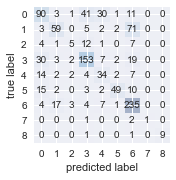

In [42]:
cm = confusion_matrix(y_target=Y_test, 
                      y_predicted=y_pred)
plot_confusion_matrix(conf_mat=cm)

# Predict eval set and export

In [43]:
#predictions
# time = 3.4443037509918213
data_eval = eval_set
start = time.time()
y_pred=model.predict_proba(data_eval)
end = time.time() - start
end

3.1941323280334473

In [135]:
y_pred[:10]

array([[  1.76787304e-04,   3.67999263e-02,   1.05749466e-03,
          3.63182917e-04,   1.52229145e-03,   1.18516102e-04,
          9.59469795e-01,   3.44077387e-04,   1.47947314e-04],
       [  3.60919476e-01,   2.56019443e-01,   1.75002415e-03,
          2.45111197e-01,   3.06237824e-02,   1.05874827e-02,
          9.16353092e-02,   8.12245766e-04,   2.54099281e-03],
       [  6.72668312e-03,   7.39872903e-02,   7.81897397e-04,
          9.73505527e-02,   7.82609545e-03,   1.80543754e-02,
          7.93792188e-01,   5.10590326e-04,   9.70293186e-04],
       [  4.59974408e-02,   2.02727377e-01,   1.57098041e-03,
          5.69430133e-03,   2.98302132e-03,   4.08400642e-03,
          7.32855320e-01,   2.80103879e-03,   1.28646905e-03],
       [  2.84846485e-01,   4.29177955e-02,   1.46236795e-03,
          3.92047793e-01,   4.84600291e-03,   1.94904171e-02,
          1.82783723e-01,   5.69610856e-02,   1.46443378e-02],
       [  3.10709655e-01,   4.95521631e-03,   3.10659147e-04,
   

In [44]:
#tweaking the submission file as required
# credit: https://www.kaggle.com/punyaswaroop12/gbm-starter-top-40
subm_file = pd.DataFrame(y_pred)
subm_file['id'] = eval_data_id
subm_file.columns = ['class1', 'class2', 'class3', 'class4', 'class5', 'class6', 'class7', 'class8', 'class9', 'id']
subm_file.to_csv(DATA_DIR+ "/submission_v2.csv",index=False)
subm_file.head(5)

,class1,class2,class3,class4,class5,class6,class7,class8,class9,id
0,0.000643,0.033051,0.000253,0.001183,0.000787,0.000815,0.962526,0.000673,0.000069,0
1,0.114828,0.443260,0.002215,0.239060,0.008873,0.017057,0.165112,0.004730,0.004867,1
2,0.015405,0.012077,0.000879,0.026846,0.005431,0.011260,0.926411,0.000747,0.000944,2
3,0.005167,0.127742,0.000259,0.001860,0.001081,0.001125,0.861658,0.000789,0.000318,3
4,0.348594,0.039986,0.001268,0.090969,0.006389,0.007912,0.396221,0.012188,0.096473,4


In [79]:
subm_file.shape

(5668, 10)